In [1]:
import jax.tools.colab_tpu
try:
    jax.tools.colab_tpu.setup_tpu()
except:
    pass

In [45]:
import jax
import jax.numpy as jnp
from jax.nn.initializers import normal as normal_init
from flax.training import train_state
from flax import linen as nn
import optax

In [29]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Load the Fashion MNIST dataset

In [30]:
# Load the Fashion MNIST dataset
def load_fashion_mnist():
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

    train_images, train_labels = train_ds['image'], train_ds['label']
    test_images, test_labels = test_ds['image'], test_ds['label']


    return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_fashion_mnist()
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28, 1), Train labels shape: (60000,)
Test images shape: (10000, 28, 28, 1), Test labels shape: (10000,)


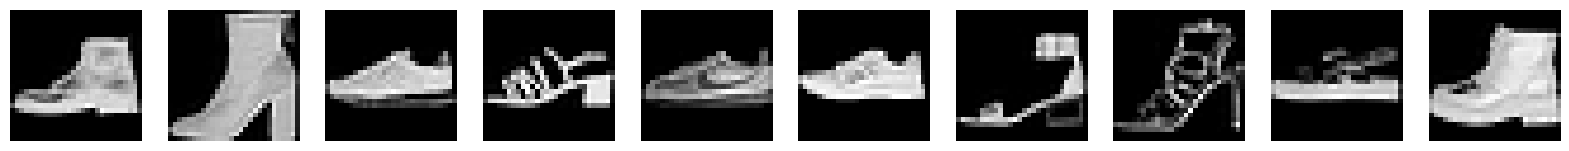

In [31]:
# Select only the images with labels 5, 7, and 9
selected_labels = jnp.array([5, 7, 9])
selected_images = train_images[jnp.isin(train_labels, selected_labels)]

# Display the first 10 images with labels 5, 7, and 9
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')
    ax.axis('off')
plt.show()

Hyperparameters

In [40]:
BATCH_SIZE = 256
SEED = 42
EPOCHS = 100
Z_DIM = 64

key = jax.random.PRNGKey(SEED)


Architecture of the Generator

In [39]:
class Generator(nn.Module):
    features: int = 64

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = x.reshape((BATCH_SIZE, 1, 1, Z_DIM))
        x = nn.ConvTranspose(self.features*4, kernel_size=(3, 3), strides=(2, 2), padding='VALID',
                             kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, dtype=jnp.float32, axis=-1,scale_init=normal_init(0.02))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(self.features*4, kernel_size=(4, 4), strides=(1, 1), padding='VALID',
                             kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, dtype=jnp.float32, axis=-1,scale_init=normal_init(0.02))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(self.features*2, kernel_size=(3, 3), strides=(2, 2), padding='VALID',
                             kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, dtype=jnp.float32, axis=-1,scale_init=normal_init(0.02))(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(1, kernel_size=(4, 4), strides=(2, 2), padding='VALID',
                             kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = jnp.tanh(x)
        return x

In [41]:
generator = Generator()
params_generator = generator.init(key, jnp.ones((BATCH_SIZE, Z_DIM), jnp.float32), train=False)

Architecture of the Discriminator

In [43]:
class Discriminator(nn.Module):
    features: int = 64

    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Conv(self.features, kernel_size=(4, 4), strides=(2, 2), padding='VALID',
                    kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, dtype=jnp.float32, axis=-1,scale_init=normal_init(0.02))(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(self.features*2, kernel_size=(4, 4), strides=(2, 2), padding='VALID',
                    kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, dtype=jnp.float32, axis=-1,scale_init=normal_init(0.02))(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(1, kernel_size=(4, 4), strides=(2, 2), padding='VALID',
                    kernel_init=normal_init(0.02), dtype=jnp.float32)(x)
        x = x.reshape((BATCH_SIZE, -1))
        return x

In [44]:
discriminator = Discriminator()
params_discriminator = discriminator.init(key, jnp.ones((BATCH_SIZE, 28, 28, 1), jnp.float32), train=False)

In [46]:
def generator_step(generator_state,
                   discriminator_state,
                   key):
    input_noise = jax.random.normal(key, (BATCH_SIZE, Z_DIM))

    def loss_fn(params):
        generated_data, mutables = generator_state.apply_fn(
                {'params': params, 'batch_stats': generator_state.batch_stats},
                input_noise, mutable=['batch_stats'])
        logits_fake = discriminator_state.apply_fn({'params': discriminator_state.params,
                                                    'batch_stats': discriminator_state.batch_stats},
                                                   generated_data, mutable=['batch_stats'])
        loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))
        return loss, mutables

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, mutables), grad = grad_fn(generator_state.params)
    # Average across the devices.
    grads = jax.lax.pmean(grads, axis_name='num_devices')
    loss = jax.lax.pmean(loss, axis_name='num_devices')

    # Update the Generator through gradient descent.
    new_generator_state = generator_state.apply_gradients(
            grads=grads, batch_stats=mutables['batch_stats'])

    return new_generator_state, loss